# Hands on Light Curve analysis

In [55]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import astropy
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.23.2
astropy: 5.1


In [57]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits

To open the fits file we use `fits.open()` and just specify the filename as an argument:

In [264]:
fits_file = fits.open('../../data/pks2155/hess/hess_dl3_dr1_obs_id_033795.fits.gz')

We can retrieve some basic information on the  header data unit (HDU) by calling `.info()`:

In [269]:
fits_file.info()

Filename: ../../data/pks2155/hess/hess_dl3_dr1_obs_id_033795.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  EVENTS        1 BinTableHDU     77   10589R x 5C   [1K, 1D, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     32   1R x 2C   [1D, 1D]   
  3  AEFF          1 BinTableHDU     47   1R x 5C   [96E, 96E, 6E, 6E, 576E]   
  4  EDISP         1 BinTableHDU     43   1R x 7C   [96E, 96E, 160E, 160E, 6E, 6E, 92160E]   
  5  PSF           1 BinTableHDU     48   1R x 7C   [32E, 32E, 6E, 6E, 144E, 144E, 27648E]   


### Events

In [270]:
events = fits_file['EVENTS']

In [271]:
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   28 / length of dimension 1                          
NAXIS2  =                10589 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
EXTNAME = 'EVENTS  '           / Extension name                                 
CREATOR = 'SASH FITS::EventListWriter' / program that created the data in this f
HDUCLASS= 'GADF    '           / Signal conformance with HEASARC/OGIP convention
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats' / D
HDUVERS = '0.2     '        

In [272]:
en = 10 * u.MeV
e_p = 1e19 * u.GeV
dist = 11*1e6 * u.lightyear

In [273]:
import astropy.constants as const

In [274]:
a = en/e_p *1e7
a.value

1.0000000000000001e-11

In [275]:
delta_T = en/e_p * (dist/const.c)

delta_T.to( u.microsecond)

<Quantity 0.3471336 us>

### PLOT SOURCE, POINTING and ON and OFF REGIONS

In [276]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

First we get the pointing postion of the telescope

In [277]:
pointing_pos =  SkyCoord( events.header.get('RA_PNT') *u.deg,   events.header.get('DEC_PNT') *u.deg )
pointing_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (329.71666667, -29.72555556)>

Then the postion of the source on the sky

In [278]:
source_name = events.header.get('OBJECT')
print(source_name)
source_pos   =  SkyCoord.from_name(events.header.get('OBJECT'))
source_pos

PKS 2155-304


<SkyCoord (ICRS): (ra, dec) in deg
    (329.71693844, -30.22558846)>

As you can see the 2 position are not the same (Why?) 

let's compute the offset

In [279]:
offset = source_pos.separation(pointing_pos)
offset.to( u.deg).value

0.5000329575814348

We now compute the angle between the source and the pointing position.


In [280]:
source_angle = pointing_pos.position_angle(source_pos).to(u.degree)
source_angle

<Angle 179.97309263 deg>

Let's now compute the angles for the off positions

In [281]:
off1_angle   = source_angle + 90*u.deg
off2_angle   = off1_angle   + 90*u.deg
off3_angle   = off2_angle   + 90*u.deg

Given the above angles, we now put the off positions on the same offset from the pointing that was used for the source

In [282]:
off1_pos = pointing_pos.directional_offset_by(position_angle=off1_angle, separation=offset)  
off2_pos = pointing_pos.directional_offset_by(position_angle=off2_angle, separation=offset)  
off3_pos = pointing_pos.directional_offset_by(position_angle=off3_angle, separation=offset) 

We can now see the results

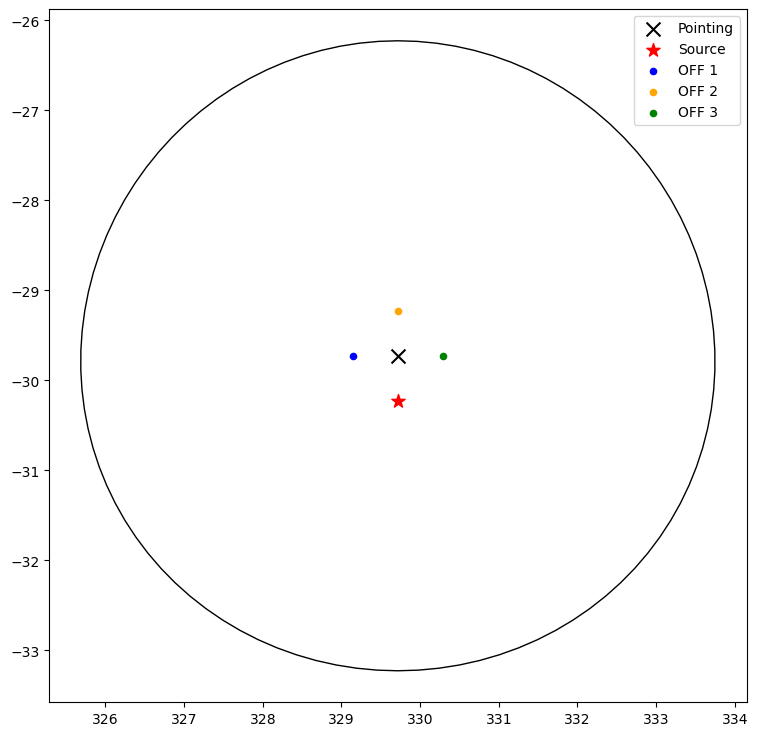

In [283]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()


field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')

ax.add_patch(field_of_view)

ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 
ax.scatter(off1_pos.ra.value, off1_pos.dec.value, marker='o', s=20, c='blue', label ='OFF 1'  ) 
ax.scatter(off2_pos.ra.value, off2_pos.dec.value, marker='o', s=20, c='orange', label ='OFF 2'  ) 
ax.scatter(off3_pos.ra.value, off3_pos.dec.value, marker='o', s=20, c='green', label ='OFF 3'  ) 
ax.legend(loc='upper right');

Or even better we can plot the On and Off regions

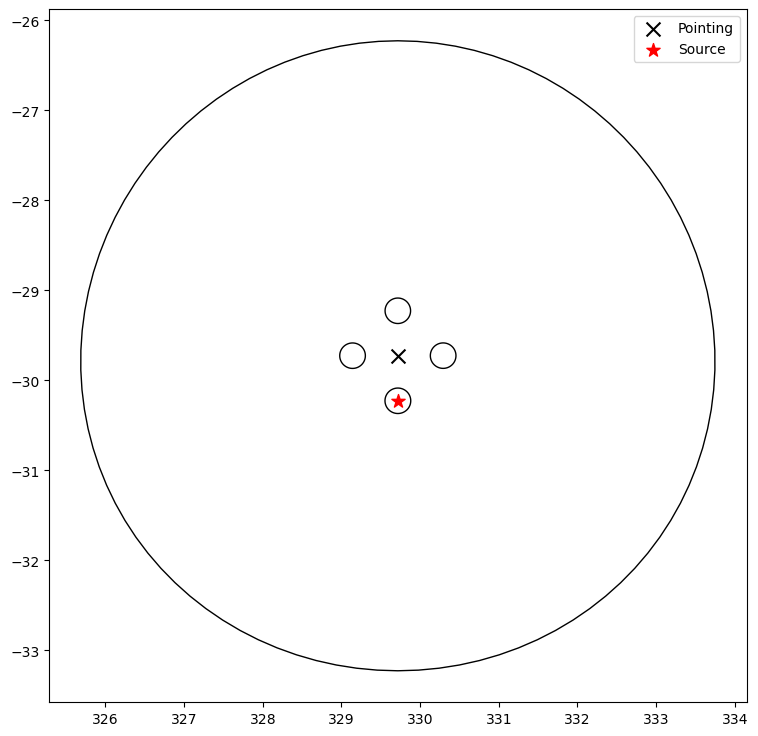

In [284]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()




field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')

radius = 0.1414213*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(field_of_view)

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)


ax.legend();

### PLOT AZIMUTH AND ALTITUDE DURING THE OBSERVATION

This is not necessary for the analysis, but it is interesting to see how the altitude and azimuth of the source evolves during the observation

In [285]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

In [286]:
ROM = EarthLocation( lat=events.header.get('GEOLAT')* u.deg, 
              lon=events.header.get('GEOLON') * u.deg, 
              height= events.header.get('ALTITUDE')*u.m)
print(ROM)

(5622482.08529426, 1665478.78910994, -2505121.94111838) m


In [287]:
start_time = Time( events.header.get('DATE-OBS') +'T'+events.header.get('TIME-OBS')) 
end_time   = Time( events.header.get('DATE-END') +'T'+events.header.get('TIME-END')) 
print(start_time)
print(end_time)

2006-07-30T00:36:58.184
2006-07-30T01:05:07.184


In [313]:
events.header.get('TSTART')

175912554.0

In [288]:
dt = ( end_time - start_time ) /100
times        = []
source_altaz = []
for i in range(100):
    time        = start_time + dt*i
    altaz        = AltAz(obstime=time, location=ROM)
    i_source_altaz = source_pos.transform_to(altaz)
    times.append( time )
    source_altaz.append( i_source_altaz )
    

In [289]:
all_alt = [  i.alt.value for i in source_altaz ]
all_az  = [  i.az.value  for i in source_altaz ]

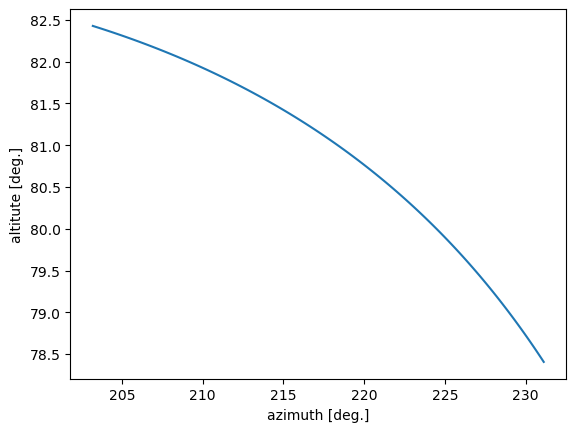

In [290]:
plt.plot(  all_az, all_alt)
plt.xlabel( "azimuth [deg.]")
plt.ylabel( "altitute [deg.]");

## GET EVENTS

We save the evtns as an Astropy Table

In [291]:
events_table = Table( events.data )
events_table

EVENT_ID,TIME,RA,DEC,ENERGY
int64,float64,float32,float32,float32
15517716840450,175912554.49393725,328.16028,-31.202658,0.20429382
15517716840455,175912554.51398373,329.66605,-30.20296,0.8453425
15517716840493,175912554.67904592,330.05206,-29.147083,0.27302635
15517716840530,175912554.87081647,328.50183,-28.31502,0.3351355
15517716840591,175912555.16137218,330.3265,-30.633415,0.2838316
15517716840592,175912555.16778064,330.3058,-29.74799,0.27672344
15517716840602,175912555.20494723,328.89536,-29.367283,0.24717121
15517716840647,175912555.44426847,330.85373,-30.4881,0.22341566
...,...,...,...,...


We then plot them "on the Sky" using the information on the RA and DEC of each single event

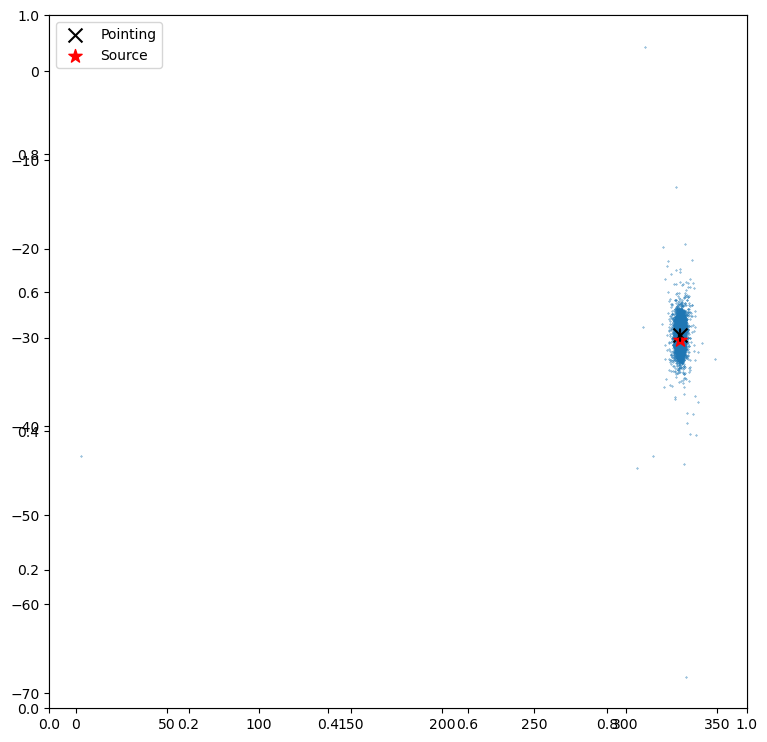

In [292]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra =   events_table['RA'] * u.deg  

dec = events_table['DEC']*u.deg

ax.scatter(ra, dec, s=0.1)


radius = 0.2*u.deg#0.1414213*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)


ax.legend();

As expected we have more events near the Source!

As one can see from the OFF regions, some of these events are not gamma-rays, but background

Rember that in the Off region we should not expect any gamma-ray

### EVENTS SELECTION

We now select the events in the 4 regions: 1 ON and 3 OFF

In [293]:
ra = events_table['RA'] 
dec = events_table['DEC']

radius = 0.2*u.deg #0.1414213*u.deg 

cond_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_on.append( source_pos.separation(position_event) <= radius )
    
cond_off1 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off1.append( off1_pos.separation(position_event) <= radius )
    
cond_off2 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off2.append( off2_pos.separation(position_event) <= radius )
    

cond_off3 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off3.append( off3_pos.separation(position_event) <= radius )
    
    

Let's plot the events we have selected

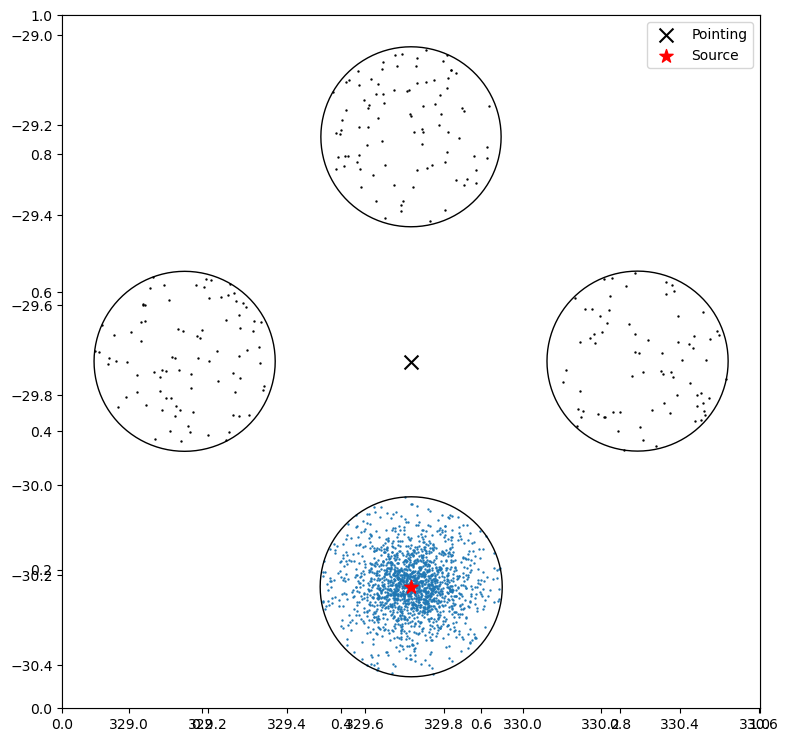

In [294]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra = events_table[cond_on]['RA'] 
dec = events_table[cond_on]['DEC']
ax.scatter(ra, dec, s=0.5)

ra = events_table[cond_off1]['RA'] 
dec = events_table[cond_off1]['DEC']
ax.scatter(ra, dec, s=0.5, c ='black')

ra = events_table[cond_off2]['RA'] 
dec = events_table[cond_off2]['DEC']
ax.scatter(ra, dec, s=0.5,  c ='black')

ra = events_table[cond_off3]['RA'] 
dec = events_table[cond_off3]['DEC']
ax.scatter(ra, dec, s=0.5,  c ='black')



ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

radius = 0.2*u.deg #0.1414213*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)



ax.legend();

### Effective Area

for computing the Light Curve we need the Total Effective Area

We will compute the Light Curbe for E > 300 GeV

In [370]:
en_th = 0.2 # TeV

We load the Effctive Area from the fits file

In [371]:
effective_area = fits_file['AEFF']

In [372]:
effective_area.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3120 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
EXTNAME = 'AEFF    '           / name of this binary table extension            
CREF5   = '(ENERG_LO:ENERG_HI,THETA_LO:THETA_HI)'                               
HDUCLASS= 'GADF    '                                                            
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'    
HDUVERS = '0.2     '        

It's better to work with an Astropy table

In [373]:
effective_area = Table( effective_area.data)

We get from the table the enrgy bins and the value ofthe Area for each bin

In [374]:
theta_low  = np.array( effective_area['THETA_LO'] )[0]
theta_high = np.array( effective_area['THETA_HI'] )[0]

en_low     = np.array( effective_area['ENERG_LO'] )[0]
en_high    = np.array( effective_area['ENERG_HI'] )[0]
en_center = np.sqrt( en_low * en_high )
delta_E  = (en_high - en_low)

eff_area   = np.array( effective_area['EFFAREA'] )[0][0]



Remove bad bins, i.e. those with Aeff = 0

In [375]:
cond = eff_area >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

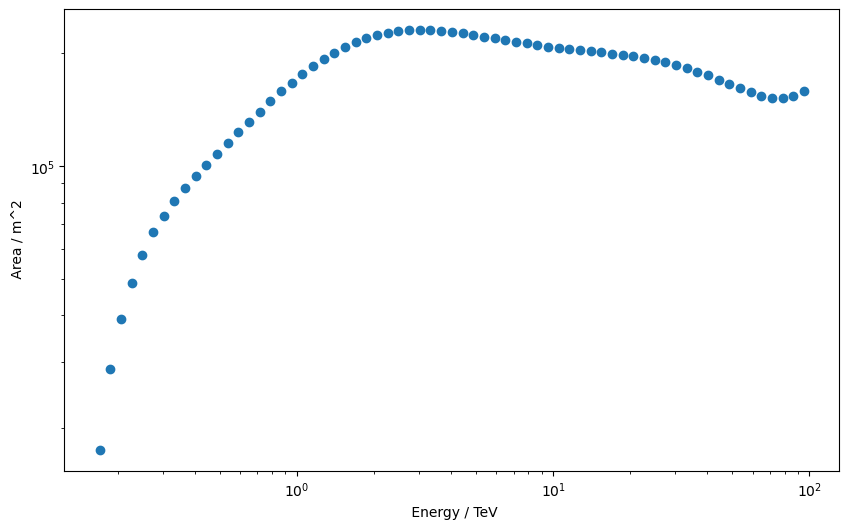

In [376]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.scatter(en_center,  eff_area)


ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Area / m^2')
ax.set_xscale('log')
ax.set_yscale('log')

We must integrate the affective area from the energy threshold up to the highest energy bin

For this integratyion we will use the function `integrate` of `scipy`

In [336]:
import scipy.integrate as integrate

In [431]:
max_en = 1#en_high[-1]
total_effective_area = integrate.quad( lambda x: np.interp(x ,  en_center, eff_area), en_th, max_en)[0] * u.m**2 * u.TeV
total_effective_area

/var/folders/cc/9yrg3qln5sq119c30p8bh2h00000gn/T/ipykernel_43836/3491535744.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_effective_area = integrate.quad( lambda x: np.interp(x ,  en_center, eff_area), en_th, max_en)[0] * u.m**2 * u.TeV


<Quantity 96034.84051601 m2 TeV>

### COMPUTE EXCESS

We are now ready to compute the ON counts, OFF counts and the excess in each time bin

First we define how many bins we want

In [432]:
n_time_bins = 10

Now we compute the bins over the whole observation time

In [433]:
events.header.get('TSTART') 

175912554.0

In [434]:
events.header.get('TSTOP') 

175914243.0

In [435]:
start_time = events.header.get('TSTART') 
end_time   = events.header.get('TSTOP') 

dt = ( end_time - start_time ) /n_time_bins
times_arr        = []
source_altaz = []
for i in range(n_time_bins+1):
    time        = start_time + dt*i
    times_arr.append( time )
    
times_arr = np.array(times_arr)

time_center = (times_arr[:-1] + times_arr[1:])/2
delta_t     =  (-times_arr[:-1] + times_arr[1:])

In [436]:
times_arr

array([1.75912554e+08, 1.75912723e+08, 1.75912892e+08, 1.75913061e+08,
       1.75913230e+08, 1.75913398e+08, 1.75913567e+08, 1.75913736e+08,
       1.75913905e+08, 1.75914074e+08, 1.75914243e+08])

In [437]:
excess = [] 
err_excess = []

noff_list = []
non_list  = []


for i_time_low, i_time_high in zip( times_arr[:-1], times_arr[1:]):
    
    cond_en_th = events_table['ENERGY'] > en_th
    
    cond_low  = events_table['TIME'] >= i_time_low
    cond_high = events_table['TIME'] < i_time_high
    cond_en   = cond_low* cond_high
    
    non    = np.sum( cond_en*cond_on * cond_en_th)
    
    noff   = np.sum( cond_en*cond_off1 * cond_en_th) +\
             np.sum( cond_en*cond_off2 * cond_en_th) +\
             np.sum( cond_en*cond_off3 * cond_en_th) 

    
    noff_list.append(noff)
    non_list.append(non)
    
    excess.append( non - noff/3 )
    err_excess.append( np.sqrt( non + (1/3)**2*noff) )
    
excess     = np.array(excess)
err_excess = np.array(err_excess)

non_list   = np.array(non_list)
noff_list   = np.array(noff_list)

Why did I put in the loop `non - noff/3` and not another number like for instance  `non - noff/5` ?

Total Non events in each energy bin

In [438]:
print(non_list)

[169 156 133 133 132 189 180 166 193 204]


Total Noff events in each energy bin

In [439]:
print(noff_list)

[16 27 26 25 25 29 28 31 22 19]


Excess in each energy bin

In [440]:
print(excess)

[163.66666667 147.         124.33333333 124.66666667 123.66666667
 179.33333333 170.66666667 155.66666667 185.66666667 197.66666667]


Excercise
- Compute the Li&Ma significance for each energy bin using the value of Non and Noff computed (remeber that we are also using $\alpha$ = 1/3)

Text(0, 0.5, ' Excess')

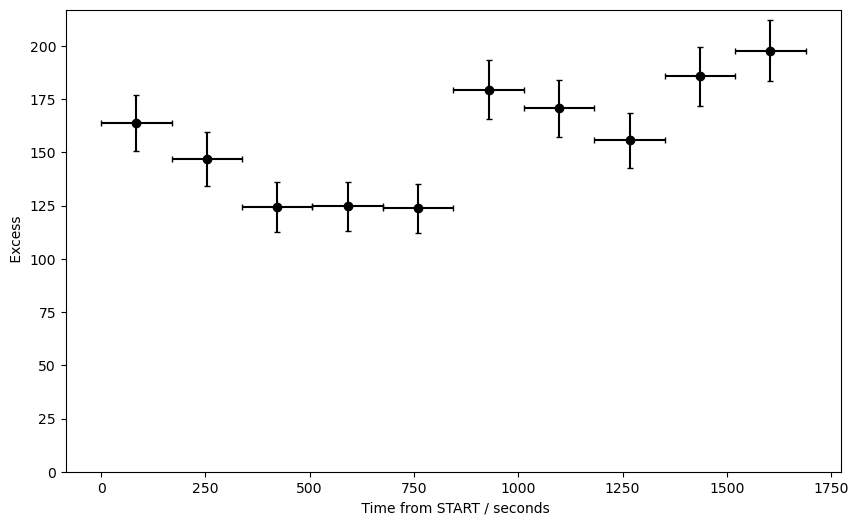

In [441]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=time_center-start_time, y=excess, yerr=err_excess , xerr = delta_t/2 , c='black', capsize=2, fmt='o')

ax.set_ylim( [0, None])
ax.set_xlabel( ' Time from START / seconds')

ax.set_ylabel( ' Excess')

### LIGHT CURVE

We are now finally ready to compute the  LC in each time bin

In [442]:
flux = excess/( total_effective_area)/   (delta_t *u.second) /  ( max_en- en_th) *u.TeV

flux_err = err_excess/( total_effective_area)/  (delta_t *u.second) / ( max_en- en_th) *u.TeV



We can now plot the flux in energy

For reference we will also print as a horizontal line the flux we should expect from the Crab Nebula

Text(0, 0.5, ' Flux > 300 GeV   / cm^2 s')

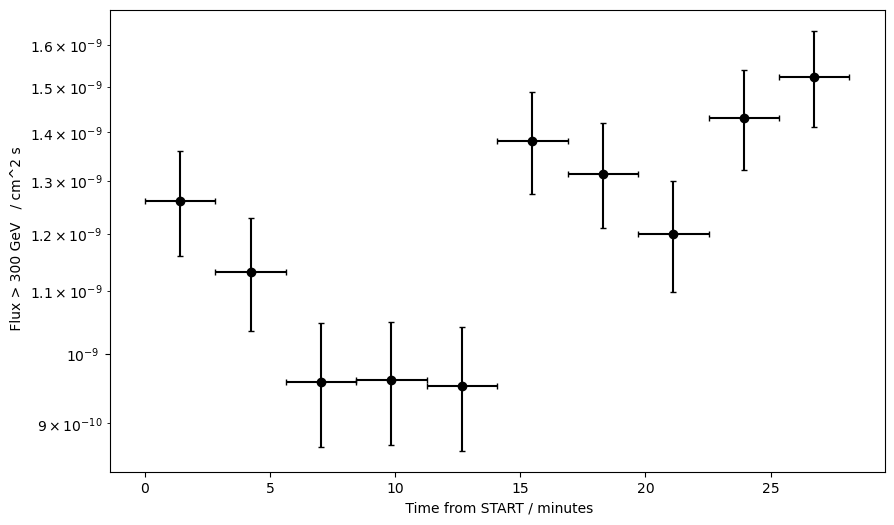

In [444]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=(time_center-start_time)/60, 
            y=flux.to( 1/(  u.cm**2 * u.s ) ).value ,#/ 1e-9 , 
            yerr = flux_err.to( 1/( u.cm**2 * u.s ) ).value , #/ 1e-9 , 
            xerr = delta_t/2/60 , c='black', capsize=2, fmt='o')



#ax.hlines( 0.12, np.min(time_center-start_time), np.max(time_center-start_time) , label='Reference Light Curve')


#ax.set_ylim( [0, None])
ax.set_xlabel( ' Time from START / minutes')
ax.set_yscale('log')

ax.set_ylabel( ' Flux > 300 GeV   / cm^2 s')

In [429]:
flux.to(  1/(  u.cm**2 * u.s * u.TeV) ) 

UnitConversionError: '1 / (m2 s)' (particle flux) and '1 / (cm2 s TeV)' are not convertible

In [430]:
flux_err.to(  1/(  u.cm**2 * u.s * u.TeV) ) 

UnitConversionError: '1 / (m2 s)' (particle flux) and '1 / (cm2 s TeV)' are not convertible

In [59]:
np.min(time_center-start_time)

297.0279405117035

In [60]:
np.max(time_center-start_time) 

297.0279405117035